In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

2024-02-07 21:10:51.742460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 21:10:51.742486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 21:10:51.742511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 21:10:51.749003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2024-02-07 21:10:53.472906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 21:10:53.477171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 21:10:53.477437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
df = pd.read_csv("../../2023-05-01.csv", nrows=100000)

In [4]:
(df["from_address"] == df["to_address"]).sum()

211

In [5]:
df = df[df["from_address"] != df["to_address"]]

In [6]:
(df["from_address"] == df["to_address"]).sum()

0

In [7]:
df.columns

Index(['block_timestamp', 'nonce', 'from_address', 'to_address', 'value',
       'gas'],
      dtype='object')

In [8]:
len(set(df['from_address']).union(set(df['to_address'])))

85775

In [9]:
df = df[~df.to_address.isna()]
df = df[~df.from_address.isna()]

In [10]:
ids = {}

for i, id in enumerate(set(df['from_address']).union(set(df['to_address']))):
    ids[id] = i

In [11]:
ids

{'0xc567fe23acf3ade7fc18f57673328df191183453': 0,
 '0x2f62d2f57f5640ee891acdff5302face3bc7eeb7': 1,
 '0x957f8fe883e854b70ebdb1f286f78b5903c359db': 2,
 '0xd3356a00a4299934ea278e4acfd6935cf5772cf1': 3,
 '0x81d3438faf7c899bf62f2bc793889c5a0dab3155': 4,
 '0x0ff531f463738ccd0fe364931021a5f0ce73ba3b': 5,
 '0xe791ef186f7a9877795939041a58149e653d1a56': 6,
 '0x50e2dd386c4ceec61e86ca74319c44cb938d6059': 7,
 '0x1d437008735ef33dc1272a8076c87f0842717c61': 8,
 '0x4f96e23ca25b8fd044914741f808424f9b20c723': 9,
 '0xb04e74cea3fb2b6c68e33dc65aa319180f229330': 10,
 '0x463b8ced7d22a55aa4a5d69ef6a54a08aa0feb93': 11,
 '0x8ed7dbccddef5e5b1e5e887a36f438765ea2bb62': 12,
 '0xd8a9fc86bec85deb3adec720bdb627663baad0d0': 13,
 '0x9f509082681e701f81666cfe3e0aef5d669cc549': 14,
 '0xe7fb5b8c9b2e25fcfd217cef4395f0980849e8ea': 15,
 '0xeea32f1b46be906acefaafabdbccd5fd34625386': 16,
 '0x22e23e60a8e64eda2f75a88cf98e7835fb619136': 17,
 '0x6a4c454ee8f0b9a97390c6752572d86c10554419': 18,
 '0x6ba662ac89800d89b07dac30e7110ebabaf63

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, BatchNormalization, Lambda, GaussianNoise


# el 1 representa a cualquier indice, un tensor de una dimensión
input_aux = Input(1)

# el 128 es arbitrario, podría ser de cualquier valor
x = Embedding(len(ids), 128)(input_aux)

x = GaussianNoise(0.02)(x)

# TODO: investigar que es esto
x = Dense(64, activation='tanh')(x)

# lleva todos los valores entre -1 y 1
output_aux = BatchNormalization()(x)

model_aux = Model(input_aux, output_aux)
model_aux.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 128)            10978176  
                                                                 
 gaussian_noise (GaussianNo  (None, 1, 128)            0         
 ise)                                                            
                                                                 
 dense (Dense)               (None, 1, 64)             8256      
                                                                 
 batch_normalization (Batch  (None, 1, 64)             256       
 Normalization)                                                  
                                                                 
Total params: 10986688 (41.91 MB)
Trainable params: 10986560 

In [13]:
# son los 3 inputs que representan las 3 cabezas de la red, lo que se conoce como siamesa
input_layer_anchor = Input(1)
input_layer_positive = Input(1)
input_layer_negative = Input(1)

x_a = model_aux(input_layer_anchor)
x_p = model_aux(input_layer_positive)
x_n = model_aux(input_layer_negative)

# un tensor es ... investigar bien. Puede ser cualquier cosa, literalmente.
merged_output = Lambda(lambda tensors: tf.stack(tensors, axis=-1))([x_a, x_p, x_n])

model = Model([input_layer_anchor, input_layer_positive, input_layer_negative], merged_output)

In [14]:
from keras.utils import Sequence
import numpy as np

class GeneratorTriplet(Sequence):
    def __init__(self, df, ids, batch_size):
        self.df = df
        self.act_index = 0
        self.ids = ids
        self.batch_size = batch_size
        self.limit = int(np.ceil(len(self.df) / self.batch_size))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.act_index < self.limit:
            resultado = self.__getitem__(self.act_index)
            self.act_index += 1
            return resultado
        else:
            raise StopIteration

    def __getitem__(self, index):
        # el Anchor es un A, el positive es un B y el negative es un C. Queremos acercar A y B tanto como sea posible alejando a C. Podría suceder que sea un vecino, pero la probabilidad es baja porque es al azar.
        # Si llegara a elegir algún vecino mal, de casualidad, en una siguiente epoch debería corregirse o inclusive en una misma epoch en una siguiente iteración del generador.
        init = index * self.batch_size
        end = (index + 1) * self.batch_size

        # el batch van a ser #batch_size tuplas que representan el anchor y positive. El negative es un random.
        batch = self.df[init:end]

        # me agarro un sample de #batch_size transacciones.
        negative = self.df.sample(len(batch))

        anchor = np.array(batch['from_address'].apply(lambda x: self.ids.get(x)))
        positive = np.array(batch['to_address'].apply(lambda x: self.ids.get(x)))
        negative = np.array(negative['to_address'].apply(lambda x: self.ids.get(x)))
        
        anchor = tf.convert_to_tensor(anchor)
        positive = tf.convert_to_tensor(positive)
        negative = tf.convert_to_tensor(negative)
        
        # el fake target simula lo que sería aprendizaje supervisado        
        fake_target = tf.convert_to_tensor(np.array([1]*self.batch_size))

        return ([anchor, positive, negative], [fake_target]*3)

In [15]:
generator = GeneratorTriplet(df, ids, 128)

In [16]:
class TripletCustom(tf.keras.losses.Loss):
    def __init__(self, margin=100.0, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def __call__(self, y, y_pred, sample_weight=None):
        anchor, positive, negative =  tf.split(y_pred, num_or_size_splits=3, axis=-1)
        distance_positive = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        distance_negative = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        loss = tf.maximum(distance_positive - distance_negative + self.margin, 0.0)
        return tf.reduce_mean(loss)

loss = TripletCustom()    

model.compile(
    optimizer=Adam(1e-3),
    loss=loss
)

In [17]:
model.fit(generator, epochs=20)

Epoch 1/20


2024-02-07 21:10:56.272082: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-07 21:10:57.804107: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd9c426e450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 21:10:57.804133: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-02-07 21:10:57.808948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-07 21:10:57.951037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-07 21:10:58.020525: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


780/780 [==============================] - 18s 19ms/step - loss: 98.0065
Epoch 2/20
780/780 [==============================] - 8s 10ms/step - loss: 93.5614
Epoch 3/20
780/780 [==============================] - 7s 9ms/step - loss: 86.2436
Epoch 4/20
780/780 [==============================] - 6s 8ms/step - loss: 78.6334
Epoch 5/20
780/780 [==============================] - 6s 8ms/step - loss: 71.5025
Epoch 6/20
780/780 [==============================] - 6s 8ms/step - loss: 65.4526
Epoch 7/20
780/780 [==============================] - 6s 7ms/step - loss: 60.4800
Epoch 8/20
780/780 [==============================] - 6s 7ms/step - loss: 55.9761
Epoch 9/20
780/780 [==============================] - 6s 7ms/step - loss: 52.3399
Epoch 10/20
780/780 [==============================] - 6s 7ms/step - loss: 48.5443
Epoch 11/20
780/780 [==============================] - 6s 8ms/step - loss: 45.0759
Epoch 12/20
780/780 [==============================] - 6s 8ms/step - loss: 41.0442
Epoch 13/20
780/780 [

# Guardo el embedding y los ids

In [18]:
embedding_matrix = model_aux.get_layer(name="embedding").get_weights()
np.array(embedding_matrix).dump("embedding_matrix.npy")

In [19]:
import pickle
with open('ids.pkl', 'wb') as f:
    pickle.dump(ids, f)

In [20]:
embedding_matrix = np.load("embedding_matrix.npy", allow_pickle=True)

In [21]:
embedding_matrix

array([[[-0.03825593,  0.13242047,  0.02872701, ..., -0.00929543,
         -0.01510014,  0.02001856],
        [ 0.13248147, -0.02042778,  0.089791  , ..., -0.03578486,
         -0.13157028,  0.167634  ],
        [-0.00846916, -0.08145966, -0.02204284, ...,  0.01608068,
          0.0596805 , -0.03560168],
        ...,
        [-0.14832392,  0.15937011, -0.25946915, ...,  0.2841883 ,
          0.20110312, -0.30889925],
        [-0.04902408, -0.08108284, -0.07405356, ..., -0.09966289,
          0.02053995, -0.09318759],
        [ 0.07932585, -0.12624438,  0.06965721, ..., -0.07698961,
          0.00352459, -0.01815226]]], dtype=float32)

In [22]:
embedding_matrix[0].shape

(85767, 128)

In [23]:
import umap
embedding = umap.UMAP(n_components=2).fit(embedding_matrix[0])

/home/lucas/.cache/pypoetry/virtualenvs/pow_a_pos-yxg4rxtc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


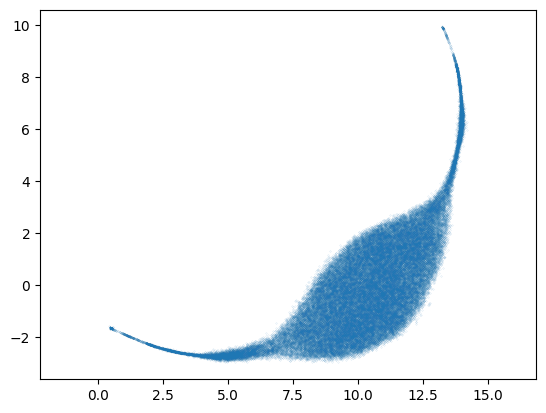

In [24]:
import matplotlib.pyplot as plt
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, s=0.02)
plt.gca().set_aspect('equal', 'datalim')
plt.show()